Domain ​- ​E-commerce  

Context ​- ​Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites. 
 
Data Description​ - Data columns-  First three columns are ​userId, productId, and ratings​ and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it. 


 Source ​- ​ ​Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.  
 
 Objective ​- ​To make a recommendation system that recommends at least five(5) new products based on the user's habits. 
 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
#read the Dataset
Data = pd.read_csv('../input/amazon-electronics-rating-datasetrecommendation/ratings_Electronics.csv',names=['userId', 'productId','Rating','timestamp'])

In [3]:
# Take the 10% Data as the Data is Huge and was cluttering the memory
Data =  Data.iloc[:782448]

In [4]:
Data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [5]:
Data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
Data.shape

(782448, 4)

In [7]:
# Take the 10% Data as the Data is Huge and was cluttering the memory
Data =  Data.iloc[:782448]

In [8]:
# Drop the Timestamp feature as it doesnt add much value to the model
Data = Data.drop(['timestamp'], axis = 1)

In [9]:
Data.shape

(782448, 3)

In [10]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(Data['Rating'].min()))
print('The maximum rating is: %d' %(Data['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


In [11]:
Data.groupby('userId')['Rating'].mean().sort_values(ascending=False).head(10)  

userId
A2W4G6C7I84MS9    5.0
A1O6EQJ9A2MV9Z    5.0
A1O6F2TRUAGBFD    5.0
A3DO545GPBJQVL    5.0
A3DO6B80J60641    5.0
A1O6F1HAFWJCX2    5.0
A3DO6XO8WQYRF5    5.0
A3DO6YJ87GYC3G    5.0
A3DO8PUU4DLF6W    5.0
A3DO9VJHDA9D8B    5.0
Name: Rating, dtype: float64

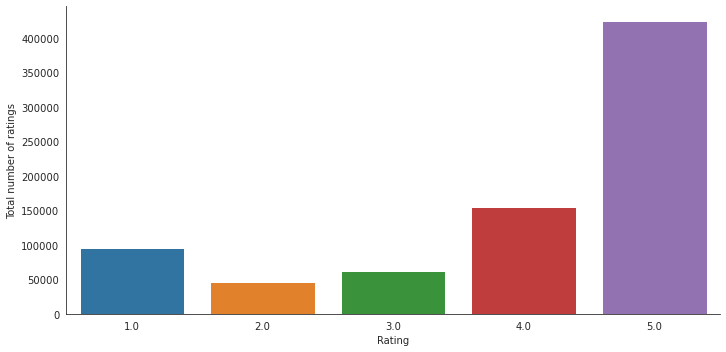

In [12]:
# check the Rating distribution in the range 1-5 for the Data given 

with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=Data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [13]:
print("Total data ")
print("*"*50)
print("\nTotal no of ratings :",Data.shape[0])
print("Total No of Users   :", len(np.unique(Data.userId)))
print("Total No of products  :", len(np.unique(Data.productId)))

Total data 
**************************************************

Total no of ratings : 782448
Total No of Users   : 606149
Total No of products  : 47105


In [14]:
#Keep the users where the user has rated more than 50 

counts1 = Data['userId'].value_counts()
#print(counts1)
Data_new = Data[Data['userId'].isin(counts1[counts1 >= 50].index)]
#counts1

In [15]:
#highest rated products from the selected records. 
Data_new.groupby('productId')['Rating'].mean().sort_values(ascending=False) 

productId
B00004Y284    5.0
B0000513SA    5.0
B000068BRE    5.0
B0000DJEIP    5.0
B00007J8SB    5.0
             ... 
B0001LGXO0    1.0
B0001PFO3C    1.0
B0001WNKBI    1.0
B0001X6GEK    1.0
1400532655    1.0
Name: Rating, Length: 2207, dtype: float64

In [16]:
#Calculate the density of the rating matrix

final_ratings_matrix = Data_new.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (27, 2207)
given_num_of_ratings =  2550
possible_num_of_ratings =  59589
density: 4.28%


In [17]:
final_ratings_matrix.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A11D1KHM7DVOQK,A12DLJESJKM1OQ,A149RNR5RH19YY,A1F9Z42CFF9IAY,A1FR68QH6Z4YZM,A1JWSDDIH5Z7DV,A1MJMYLRTZ76ZX,A1RPTVW5VEOSI,A203OCQQ12MAVT,A231WM2Z2JL0U3,...,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A6FIAB28IS79,A7Y6AVS576M03,ABH9D1TEOJ56E,AGHZXQL9F94T9,AGXV8E7XK9J6H,AKT8TGIT6VVZ5,AT2J7H5TRZM8Z,AT6CZDCP4TRGA
productId,,,,,,,,,,,,,,,,,,,,,
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000O48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000001OL6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000001OMN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000J05A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# #Build Popularity Recommender model. (Non-personalised)¶

In [19]:
#Count of user_id for each unique product as recommendation score 
Data_new_grouped = Data_new.groupby('productId').agg({'userId': 'count'}).reset_index()
Data_new_grouped.rename(columns = {'userId': 'score'},inplace=True)
Data_new_grouped.head()

,productId,score
0,1400532655,1
1,B000000O48,1
2,B000001OL6,1
3,B000001OMN,1
4,B00000J05A,1


In [20]:
#Sort the products on recommendation score 
train_data_sort = Data_new_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
113,B00004SB92,6,1.0
1099,B00008OE6I,5,2.0
368,B00005AW1H,4,3.0
612,B0000645C9,4,4.0
976,B00007KDVI,4,5.0


In [21]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [22]:
find_recom = [15,21,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      userId   productId  score  Rank
113       15  B00004SB92      6   1.0
1099      15  B00008OE6I      5   2.0
368       15  B00005AW1H      4   3.0
612       15  B0000645C9      4   4.0
976       15  B00007KDVI      4   5.0


Here is the recommendation for the userId: 21

      userId   productId  score  Rank
113       21  B00004SB92      6   1.0
1099      21  B00008OE6I      5   2.0
368       21  B00005AW1H      4   3.0
612       21  B0000645C9      4   4.0
976       21  B00007KDVI      4   5.0


Here is the recommendation for the userId: 53

      userId   productId  score  Rank
113       53  B00004SB92      6   1.0
1099      53  B00008OE6I      5   2.0
368       53  B00005AW1H      4   3.0
612       53  B0000645C9      4   4.0
976       53  B00007KDVI      4   5.0




#If we see all the recommendations for all the users are the same.. it is not user dependent for one which
#look for recommendations.
#The user iD level recommendation and the general recommedation are the same

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

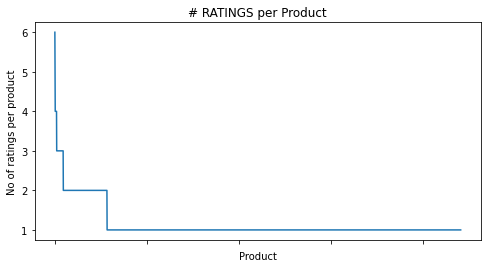

In [23]:
no_of_ratings_per_product = Data_new.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

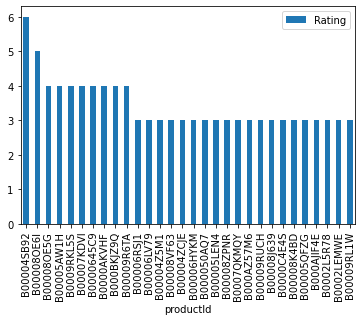

In [24]:
# Top 30 recommendations for the users

popular_products = pd.DataFrame(Data_new.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")


Since this is a popularity-based recommender model, recommendations remain the same for all users which we have given in the input

We predict the products based on the popularity. It is not personalized to particular user


# ****collaborative Filtering using KNN****

In [25]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from collections import defaultdict

In [26]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data1 = Dataset.load_from_df(Data_new,reader)
data1

In [27]:
Data_new

,userId,productId,Rating
2162,A5JLAU2ARJ0BO,1400532655,1.0
7381,A2AEZQ3DGBBLPR,B000000O48,5.0
7448,A2R6RA8FRBS608,B000001OL6,4.0
7789,A11D1KHM7DVOQK,B000001OMN,2.0
8732,A6FIAB28IS79,B00000J05A,3.0
...,...,...,...
778203,A3OXHLG6DIBRW8,B000BSOBG0,4.0
779341,AKT8TGIT6VVZ5,B000BTFZZA,5.0
780932,A149RNR5RH19YY,B000BTL0OA,5.0
781740,A1RPTVW5VEOSI,B000BTPVHW,3.0


In [28]:
#Splitting the dataset
trainset, testset = train_test_split(data1, test_size=0.3,random_state=10)

1) Trainset is no longer a pandas dataframe. Rather, it's a specific datatypes defined by the Surprise library

2) UserID and product ID in the pandas dataframe can contain any value (either string/integer etc). However, Trainset convert these raw ids into numeric indexes called as "inner id"


In [29]:
trainset.ur

defaultdict(list,
            {0: [(0, 4.0),
              (10, 5.0),
              (50, 1.0),
              (64, 4.0),
              (70, 4.0),
              (85, 4.0),
              (96, 3.0),
              (112, 4.0),
              (121, 4.0),
              (145, 4.0),
              (177, 4.0),
              (185, 5.0),
              (214, 4.0),
              (216, 3.0),
              (231, 4.0),
              (234, 1.0),
              (241, 2.0),
              (249, 3.0),
              (255, 4.0),
              (262, 5.0),
              (343, 1.0),
              (345, 5.0),
              (347, 1.0),
              (353, 2.0),
              (364, 2.0),
              (414, 3.0),
              (422, 4.0),
              (449, 4.0),
              (484, 3.0),
              (490, 4.0),
              (499, 2.0),
              (521, 4.0),
              (526, 4.0),
              (529, 5.0),
              (590, 2.0),
              (628, 2.0),
              (629, 4.0),
              (659, 2.0),

In [30]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [31]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [32]:
test_pred

[Prediction(uid='A25HBO5V8S8SEA', iid='B0000DK3I4', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1F9Z42CFF9IAY', iid='B00001WRSJ', r_ui=2.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1MJMYLRTZ76ZX', iid='B00004YZLV', r_ui=5.0, est=4.608695652173913, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0007KQWF0', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00008BO91', r_ui=5.0, est=4.197759103641457, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00006HCCS', r_ui=5.0, est=3.9660377358490564, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AT2J7H5TRZM8Z', iid='B00006JM1W', r_ui=4.0, est=4.197759103641457

In [33]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [34]:
top_n = get_top_n(test_pred, n=5)

In [35]:
top_n

defaultdict(list,
            {'A25HBO5V8S8SEA': [('B0000691IO', 5),
              ('B00005ICE1', 5),
              ('B00007KDVI', 4.975806451612903),
              ('B00006HCHH', 4.975806451612903),
              ('B00006HXF4', 4.975806451612903)],
             'A1F9Z42CFF9IAY': [('B00001WRSJ', 4.197759103641457),
              ('B000BJSEQW', 4.197759103641457),
              ('B00007E7QS', 4.197759103641457),
              ('B00078GLJY', 4.197759103641457),
              ('B00007H08Y', 4.197759103641457)],
             'A1MJMYLRTZ76ZX': [('B00004YZLV', 4.608695652173913),
              ('B00007B6L5', 4.608695652173913),
              ('B00005NHH8', 4.608695652173913),
              ('B000031KIM', 4.608695652173913),
              ('B000BKJZ9Q', 4.608695652173913)],
             'A5JLAU2ARJ0BO': [('B00008OE6I', 4.262334032145352),
              ('B0007KQWF0', 4.197759103641457),
              ('B00008BO91', 4.197759103641457),
              ('B00006HYWR', 4.197759103641457),
         

In [36]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A25HBO5V8S8SEA ['B0000691IO', 'B00005ICE1', 'B00007KDVI', 'B00006HCHH', 'B00006HXF4']
A1F9Z42CFF9IAY ['B00001WRSJ', 'B000BJSEQW', 'B00007E7QS', 'B00078GLJY', 'B00007H08Y']
A1MJMYLRTZ76ZX ['B00004YZLV', 'B00007B6L5', 'B00005NHH8', 'B000031KIM', 'B000BKJZ9Q']
A5JLAU2ARJ0BO ['B00008OE6I', 'B0007KQWF0', 'B00008BO91', 'B00006HYWR', 'B00006484F']
AT2J7H5TRZM8Z ['B00006JM1W', 'B00005BIB8', 'B00006484F', 'B00000J4FS', 'B0000635UX']
A231WM2Z2JL0U3 ['B0000630TO', 'B000021YUO', 'B00004SB92', 'B00001YVG4', 'B00004SCKA']
A2AEZQ3DGBBLPR ['B00005QXWI', 'B00005YTX0', 'B00006ANXP', 'B00004Y2MM', 'B00004X084']
AGXV8E7XK9J6H ['B0007Y794O', 'B0001D3K8A', 'B00009XVBU', 'B0007NIB74', 'B00091SBU6']
AGHZXQL9F94T9 ['B000069BJ9', 'B0002IONG2', 'B00008MZ0B', 'B0007MVHZS', 'B00008L3HI']
A6FIAB28IS79 ['B0007LJHVA', 'B00005138B', 'B0007LJHVK', 'B0006N2P8Q', 'B0001FV3AK']
A3OXHLG6DIBRW8 ['B000067VBL', 'B00004ZCJE', 'B0000ARKWY', 'B00006IJO9', 'B00006JQLB']
A12DLJESJKM1OQ ['B00008OE5I', 'B0000DBJJT', 'B000087L74', 'B

Try with an example of USER id from the above list and see if it matches the same results. 

In [37]:
uid = "A11D1KHM7DVOQK"  # raw user id (as in the ratings file). They are **strings**!
iid = "B000059L44"  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=0.0, verbose=True)

user: A11D1KHM7DVOQK item: B000059L44 r_ui = 0.00   est = 4.20   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Below is the top 5 recommendations from we got above functions. We can check if this is coming same below A11D1KHM7DVOQK ['B000059L44', 'B00001ZWRV', 'B00000J1G6', 'B00008RS96', 'B00004T8R2']

In [38]:
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == 'A11D1KHM7DVOQK'][['iid', 'r_ui','est']].sort_values(by = 'est',ascending = False).head(10)

,iid,r_ui,est
45,B000059L44,1.0,4.197759
49,B00001ZWRV,3.0,4.197759
725,B00005V54U,5.0,4.197759
711,B0007Y6AD0,4.0,4.197759
696,B00029TN9S,3.0,4.197759
687,B000095SB6,1.0,4.197759
683,B00009XSXN,4.0,4.197759
682,B00004Z0BN,3.0,4.197759
677,B000094JJL,2.0,4.197759
671,B00005B9W6,1.0,4.197759


In [39]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.2378


1.2378262599833756

# collaborative Filtering using SVD

In [40]:
from collections import defaultdict
from surprise import SVD
from surprise import Dataset

In [41]:
data1 = Dataset.load_from_df(Data_new,reader)
data1
trainset, testset = train_test_split(data1, test_size=.15)

In [42]:
trainset

In [43]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (63, 5.0),
              (71, 5.0),
              (101, 1.0),
              (106, 5.0),
              (134, 5.0),
              (150, 5.0),
              (155, 5.0),
              (214, 4.0),
              (234, 5.0),
              (262, 5.0),
              (301, 5.0),
              (342, 5.0),
              (382, 5.0),
              (403, 5.0),
              (417, 3.0),
              (434, 4.0),
              (447, 4.0),
              (465, 5.0),
              (467, 5.0),
              (487, 5.0),
              (494, 5.0),
              (506, 5.0),
              (512, 5.0),
              (520, 3.0),
              (547, 4.0),
              (588, 4.0),
              (595, 5.0),
              (599, 4.0),
              (663, 5.0),
              (697, 5.0),
              (758, 4.0),
              (761, 3.0),
              (771, 5.0),
              (791, 5.0),
              (792, 3.0),
              (860, 5.0),
              (747, 4

In [44]:
algo_svd = SVD(n_factors=5,biased=False)
algo_svd.fit(trainset)

In [45]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

In [46]:
testset

[('A2B7BUH8834Y6M', 'B00008OE6I', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00004XRED', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B0001YEOCU', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00009RL1X', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B000083K0Q', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00006I53X', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00009XFMF', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00005UT2U', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B000083K05', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B0002ZH6PU', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B000BKJZ9Q', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B0000E68U2', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00005T3V9', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00006B9HP', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00000K4KH', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00008RUEO', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B0002L5R78', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B00062PN6I', 4.180433779418551),
 ('A2B7BUH8834Y6M', 'B0000DF

In [47]:
predictions = algo_svd.test(testset)

In [48]:
predictions

[Prediction(uid='A2B7BUH8834Y6M', iid='B00008OE6I', r_ui=4.180433779418551, est=1, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00004XRED', r_ui=4.180433779418551, est=1, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B0001YEOCU', r_ui=4.180433779418551, est=1, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00009RL1X', r_ui=4.180433779418551, est=1.0155483395343345, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B000083K0Q', r_ui=4.180433779418551, est=1.9440834998538545, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00006I53X', r_ui=4.180433779418551, est=1, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00009XFMF', r_ui=4.180433779418551, est=1.1886224590900503, details={'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B00005UT2U', r_ui=4.180433779418551, est=1, details={'was_impossible': False}

In [49]:
top_n = get_top_n(predictions, n=5)

In [50]:
top_n

defaultdict(list,
            {'A2B7BUH8834Y6M': [('B0001LSDUC', 3.1334992588899344),
              ('B0001AUB3K', 2.9059817621932074),
              ('B00005ICE3', 2.8918120343769584),
              ('B00005NHH8', 2.8818591059328607),
              ('B000068IL8', 2.8742252885135624)],
             'A12DLJESJKM1OQ': [('B00006IW1X', 2.2121688145583844),
              ('B00005QEY4', 2.0869928279653043),
              ('B0002Z240M', 1.9836999611330333),
              ('B00067LYFW', 1.9789133277092887),
              ('B00001OPK2', 1.9648695122052546)],
             'AGHZXQL9F94T9': [('B00009R6WO', 1.7767836829774866),
              ('B00007H4LM', 1.646592726704712),
              ('B00005LE77', 1.6461545326009228),
              ('B00005LENO', 1.6316119885580826),
              ('B000071NY3', 1.6149225335167243)],
             'A1FR68QH6Z4YZM': [('B00004Z5M1', 4.132033885389955),
              ('B0000645C8', 3.3993052631374967),
              ('B00005V619', 3.264258050989593),
           

In [51]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2B7BUH8834Y6M ['B0001LSDUC', 'B0001AUB3K', 'B00005ICE3', 'B00005NHH8', 'B000068IL8']
A12DLJESJKM1OQ ['B00006IW1X', 'B00005QEY4', 'B0002Z240M', 'B00067LYFW', 'B00001OPK2']
AGHZXQL9F94T9 ['B00009R6WO', 'B00007H4LM', 'B00005LE77', 'B00005LENO', 'B000071NY3']
A1FR68QH6Z4YZM ['B00004Z5M1', 'B0000645C8', 'B00005V619', 'B000065BPC', 'B0000632FZ']
A5JLAU2ARJ0BO ['B0000898TE', 'B000182FHW', 'B00006JI6U', 'B00007LKHY', 'B00005AC8J']
A25HBO5V8S8SEA ['B00005T3T6', 'B00008OE5G', 'B00005NK38', 'B00009R6WO', 'B0000AKVHF']
AKT8TGIT6VVZ5 ['B00004SB92', 'B00004Z5M1', 'B00008OE5G', 'B00004Y2MM', 'B000083EAI']
A231WM2Z2JL0U3 ['B00007LKHY', 'B00005LEN4', 'B00005LE77', 'B00006I57Q', 'B0000AGAWV']
A11D1KHM7DVOQK ['B000BKJZ9Q', 'B0000645C8', 'B00005LB8P', 'B00006I5E4', 'B00004Z5M1']
A1F9Z42CFF9IAY ['B000086A17', 'B00004XRED', 'B0001YEOCU', 'B00009RL1X', 'B000083K0Q']
A203OCQQ12MAVT ['B00026KJ26', 'B00006JI6U', 'B0000AAAJR', 'B00005NFPH', 'B00007E361']
AT2J7H5TRZM8Z ['B000BKJZ9Q', 'B00009IB70', 'B00091SBU6', 

In [52]:
# compute RMSE
accuracy.rmse(predictions)

RMSE: 3.0645


3.0644658947410135

Summarise Findings.

Model predicts average rating wherever estimation is not possible

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.

RMSE score for the KNN with Means is better than the SVD model , So we will go with the KNN with means

Estimates Rating of the KNN with means were better than the SVD model


# Try manual way of SVD (optional)¶

In [53]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = Data_new.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

(27, 2207)

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [55]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [57]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
0,0.010806,0.007640,0.341710,0.019486,0.020262,0.001071,0.061845,0.001528,0.341710,0.009743,...,0.055382,0.147149,0.074009,0.059207,0.427137,0.059207,-0.010223,0.006481,0.000643,0.059207
1,-0.008841,-0.151711,-0.418987,-0.012224,0.006431,0.102874,-0.233518,-0.030342,-0.418987,-0.006112,...,-0.006964,-0.404575,0.227817,0.182254,-0.523734,0.182254,-0.094937,0.054510,0.061724,0.182254
2,0.003798,-0.001514,0.021897,0.002592,0.168310,-0.000009,0.043804,-0.000303,0.021897,0.001296,...,0.288113,0.040260,0.019545,0.015636,0.027371,0.015636,-0.005451,0.018710,-0.000005,0.015636
3,0.005073,-0.026200,0.060928,0.007471,0.120336,0.041956,0.003090,-0.005240,0.060928,0.003735,...,0.210705,0.250083,0.069759,0.055807,0.076160,0.055807,0.040640,0.016526,0.025174,0.055807
4,0.014380,-0.019232,0.068609,0.006567,0.052054,0.017235,0.001601,-0.003846,0.068609,0.003284,...,0.115516,0.119546,0.065698,0.052559,0.085761,0.052559,0.763848,0.014514,0.010341,0.052559


In [58]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [59]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00005T3DP                  0.0          0.728172
B00000J0E8                  0.0          0.690441
B000BLHZO2                  0.0          0.690441
B00004RG7J                  0.0          0.690441
B000050MG3                  0.0          0.690441


In [60]:
# Predicted ratings 
preds_df.head()

productId,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000BQ57BU,B000BQ7GW8,B000BQVYIA,B000BSLTIS,B000BSLTMY,B000BSOBG0,B000BTFZZA,B000BTL0OA,B000BTPVHW,B000BTQXUG
0,0.010806,0.007640,0.341710,0.019486,0.020262,0.001071,0.061845,0.001528,0.341710,0.009743,...,0.055382,0.147149,0.074009,0.059207,0.427137,0.059207,-0.010223,0.006481,0.000643,0.059207
1,-0.008841,-0.151711,-0.418987,-0.012224,0.006431,0.102874,-0.233518,-0.030342,-0.418987,-0.006112,...,-0.006964,-0.404575,0.227817,0.182254,-0.523734,0.182254,-0.094937,0.054510,0.061724,0.182254
2,0.003798,-0.001514,0.021897,0.002592,0.168310,-0.000009,0.043804,-0.000303,0.021897,0.001296,...,0.288113,0.040260,0.019545,0.015636,0.027371,0.015636,-0.005451,0.018710,-0.000005,0.015636
3,0.005073,-0.026200,0.060928,0.007471,0.120336,0.041956,0.003090,-0.005240,0.060928,0.003735,...,0.210705,0.250083,0.069759,0.055807,0.076160,0.055807,0.040640,0.016526,0.025174,0.055807
4,0.014380,-0.019232,0.068609,0.006567,0.052054,0.017235,0.001601,-0.003846,0.068609,0.003284,...,0.115516,0.119546,0.065698,0.052559,0.085761,0.052559,0.763848,0.014514,0.010341,0.052559


In [61]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400532655    0.039313
B000000O48   -0.004927
B000001OL6    0.191699
B000001OMN    0.014027
B00000J05A    0.135212
dtype: float64

In [62]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(2207, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.037037,0.039313,0
B000000O48,0.185185,-0.004927,1
B000001OL6,0.148148,0.191699,2
B000001OMN,0.074074,0.014027,3
B00000J05A,0.111111,0.135212,4


In [63]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.08122 



In [64]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B00005T3DP                  0.0          0.728172
B00000J0E8                  0.0          0.690441
B000BLHZO2                  0.0          0.690441
B00004RG7J                  0.0          0.690441
B000050MG3                  0.0          0.690441


Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 12 & 20, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history

We will go with the KNN with means recommender system if we have got user rating avaialable and popularity based in case of cold start
